In [1]:
# !pip install ultralytics

In [2]:
# Required Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from ultralytics import YOLO

In [3]:
# Load dataset
TRAIN_DATA_DIR = "./Train"
CSV_FILE = os.path.join(TRAIN_DATA_DIR, "_annotations.csv")
df = pd.read_csv(CSV_FILE)

### Exploratory data analysis

In [4]:
# Basic info about dataset
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    11550 non-null  object 
 1   width       11550 non-null  int64  
 2   height      11550 non-null  int64  
 3   class       11550 non-null  object 
 4   xmin        11550 non-null  int64  
 5   ymin        11550 non-null  int64  
 6   xmax        11550 non-null  int64  
 7   ymax        11550 non-null  int64  
 8   Unnamed: 8  0 non-null      float64
dtypes: float64(1), int64(6), object(2)
memory usage: 812.2+ KB


In [5]:
# Number of unique images in dataset
df['filename'].nunique()

1011

In [6]:
# Class Distribution
df['class'].value_counts()

class
diode        9772
hotspot      1616
no_defect     162
Name: count, dtype: int64

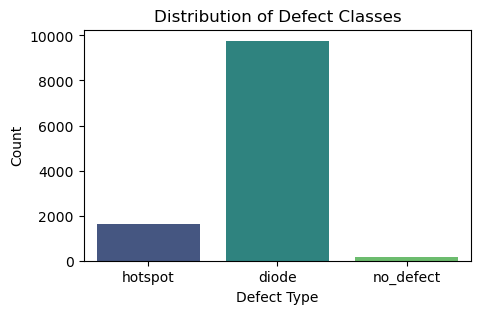

In [7]:
# Plot class distribution
plt.figure(figsize=(5, 3))
sns.countplot(x=df['class'], palette='viridis', hue=df['class'], legend=False)
plt.title('Distribution of Defect Classes')
plt.xlabel('Defect Type')
plt.ylabel('Count')
plt.show()

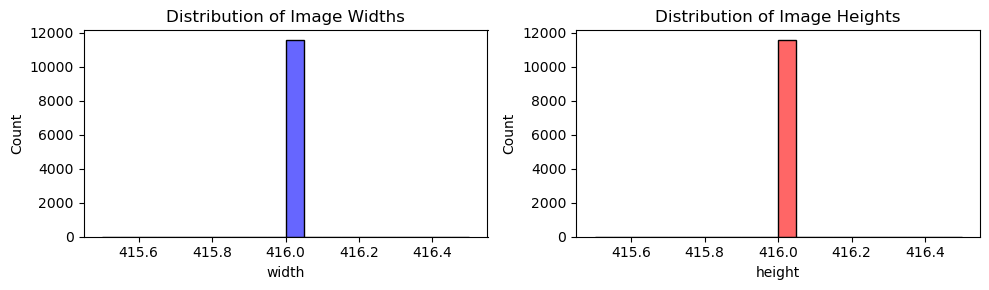

In [8]:
# Plot image size distributions
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.histplot(df['width'], bins=20, kde=True, color='blue', alpha=0.6)
plt.title('Distribution of Image Widths')

plt.subplot(1, 2, 2)
sns.histplot(df['height'], bins=20, kde=True, color='red', alpha=0.6)
plt.title('Distribution of Image Heights')

plt.tight_layout()
plt.show()

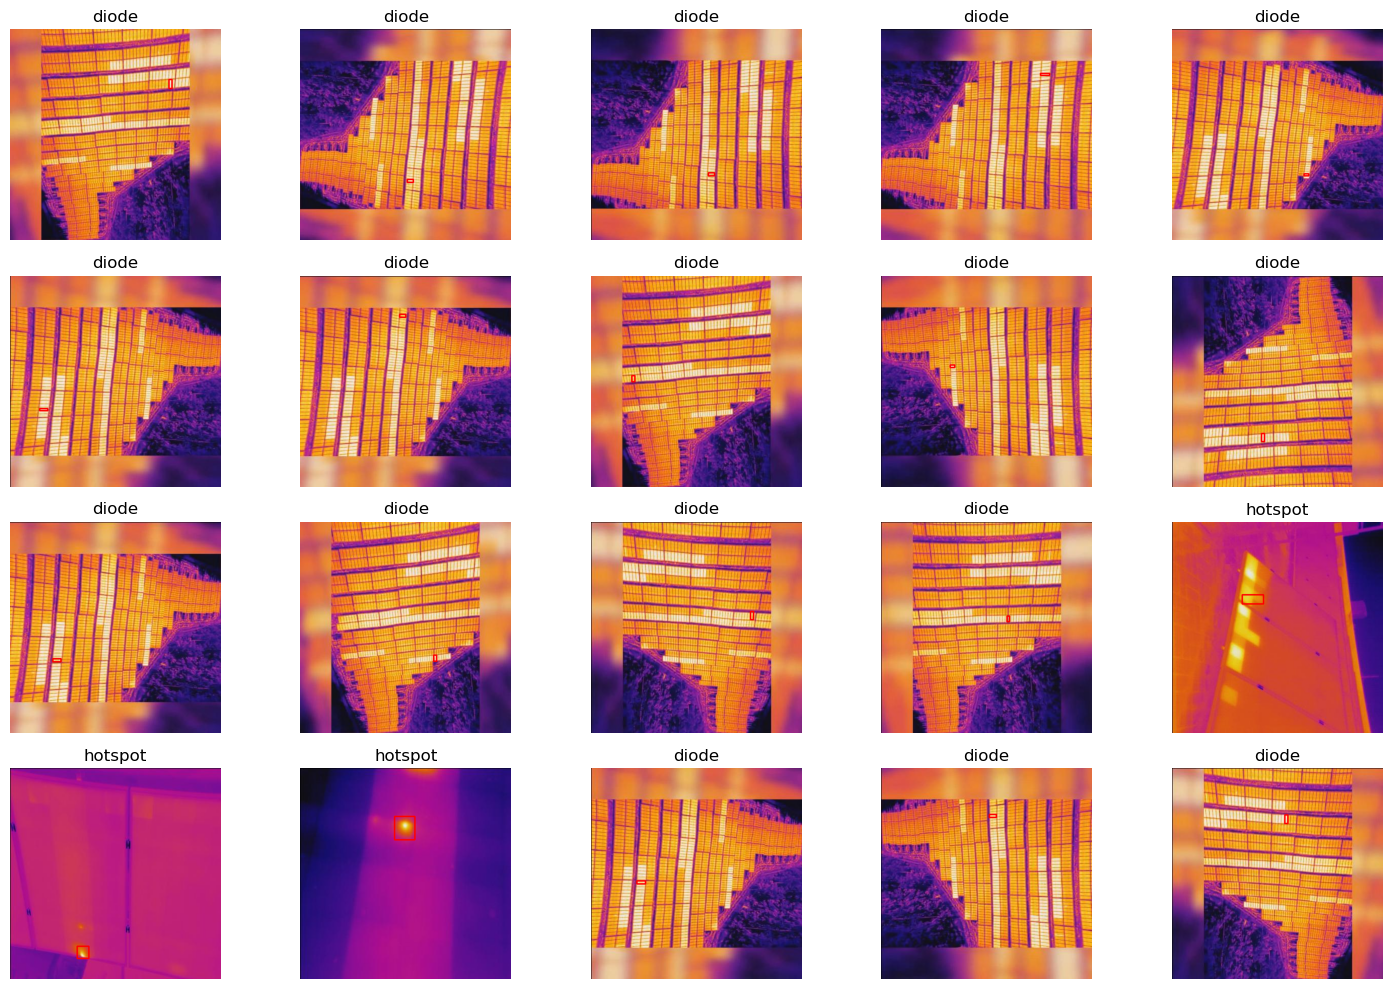

In [9]:
# Visualizing some images with annotations
def plot_sample_images(df, data_dir, num_samples=20):
    sample_images = df.sample(num_samples)
    rows = 4
    cols = num_samples // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    
    for idx, (ax, row) in enumerate(zip(axes.flatten(), sample_images.iterrows())):
        row = row[1]
        img_path = os.path.join(data_dir, row['filename'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw bounding box
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        
        ax.imshow(image)
        ax.set_title(row['class'])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images(df, "Train/")

### Model training

In [10]:
# Prepare YOLO Dataset Paths
yolo_images_dir = "./yolo_dataset/images"
yolo_labels_dir = "./yolo_dataset/labels"
os.makedirs(yolo_images_dir, exist_ok=True)
os.makedirs(yolo_labels_dir, exist_ok=True)

In [11]:
# Mapping class labels to YOLO format
defect_mapping = {'hotspot': 0, 'diode': 1, 'no_defect': 2}
df['class'] = df['class'].map(defect_mapping)

In [12]:
# Convert annotation format to YOLO format
def convert_bbox_format(row, img_width, img_height):
    """
    Converts bounding box coordinates to YOLO format.
    """
    if row['class'] == 2:  # Ignore 'no_defect' cases
        return ""
    x_center = (row['xmin'] + row['xmax']) / (2 * img_width)
    y_center = (row['ymin'] + row['ymax']) / (2 * img_height)
    width = (row['xmax'] - row['xmin']) / img_width
    height = (row['ymax'] - row['ymin']) / img_height
    return f"{row['class']} {x_center} {y_center} {width} {height}\n"

In [13]:
# Process Images and Labels
yolo_labels = {}
for _, row in df.iterrows():
    image_path = os.path.join(TRAIN_DATA_DIR, row['filename'])
    new_image_path = os.path.join(yolo_images_dir, row['filename'])
    
    # Read image once to avoid redundancy
    img = cv2.imread(image_path)
    if img is None:
        continue  # Skip if image is missing
    
    img_height, img_width = img.shape[:2]
    cv2.imwrite(new_image_path, img)  # Save image in YOLO dataset
    
    label_entry = convert_bbox_format(row, img_width, img_height)
    if label_entry:
        yolo_labels.setdefault(row['filename'], []).append(label_entry)

# Write Labels to Files
for filename, labels in yolo_labels.items():
    label_path = os.path.join(yolo_labels_dir, filename.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        f.writelines(labels)

print("YOLO dataset preparation completed!")

YOLO dataset preparation completed!


In [14]:
# Creating YOLO Data Config File (note - add full path for train and val directory)
data_yaml = """
train: /home/jovyan/projects/yolo_dataset/images
val: /home/jovyan/projects/yolo_dataset/images
nc: 2
names: ['hotspot', 'diode']
"""
with open("./yolo_dataset/data.yaml", "w") as f:
    f.write(data_yaml)

In [15]:
# YOLO Model Training
def train_yolo_model():
    """
    Trains the YOLO model on the dataset while suppressing detailed curve results.
    """
    model = YOLO("yolov8n.pt")  # Load pretrained YOLOv8 model
    model.train(data="./yolo_dataset/data.yaml", epochs=50, batch=8, imgsz=416, verbose=False)
    model.save("best.pt")  # Save the trained model
    print("YOLO model training completed!")

In [16]:
# Train YOLO Model
train_yolo_model()

100%|██████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 6.68MB/s]


Ultralytics 8.3.83 🚀 Python-3.11.6 torch-2.6.0+cu124 CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /home/jovyan/projects/yolo_dataset/labels... 849 images, 162 backgrounds, 0 corrupt: 100%|██████████| 10


train: New cache created: /home/jovyan/projects/yolo_dataset/labels.cache


val: Scanning /home/jovyan/projects/yolo_dataset/labels.cache... 849 images, 162 backgrounds, 0 corrupt: 100%|██████████

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.502      2.768      1.234          7        416: 100%|██████████| 127/127 [01:53<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:06<


                   all       1011      11388      0.344      0.278      0.217       0.08

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G       2.54      2.041       1.21          3        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:07<


                   all       1011      11388      0.347      0.394      0.261     0.0872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.456      1.896      1.227          3        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<


                   all       1011      11388       0.31      0.364      0.265      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       2.48      1.738      1.199         41        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<


                   all       1011      11388       0.36      0.419      0.272      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.465      1.639      1.193        164        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<

                   all       1011      11388       0.39      0.403      0.292      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G        2.4      1.516      1.162        184        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:02<

                   all       1011      11388      0.451      0.464      0.337      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.344      1.466      1.164         18        416: 100%|██████████| 127/127 [01:52<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.408       0.46      0.351      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.295      1.369      1.166          5        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<


                   all       1011      11388      0.424      0.455      0.347      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       2.22      1.327      1.173         27        416: 100%|██████████| 127/127 [01:48<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.467      0.515      0.405      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.303       1.33      1.142          4        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<


                   all       1011      11388      0.464      0.494      0.367      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.289      1.348      1.128         11        416: 100%|██████████| 127/127 [01:49<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<

                   all       1011      11388      0.439      0.537      0.401      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.227      1.269      1.143        158        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.442      0.516      0.418      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.254      1.211      1.112         49        416: 100%|██████████| 127/127 [01:52<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:02<

                   all       1011      11388      0.475      0.524      0.403      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.213      1.239      1.124          2        416: 100%|██████████| 127/127 [01:49<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.431      0.518      0.419      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.233      1.221      1.122          1        416: 100%|██████████| 127/127 [01:49<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.456      0.554      0.441      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.203      1.191      1.129          6        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.467      0.543      0.428      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.159      1.186      1.131          5        416: 100%|██████████| 127/127 [01:49<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.441      0.556      0.429      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      2.294        1.2      1.092          3        416: 100%|██████████| 127/127 [01:53<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<

                   all       1011      11388      0.474      0.557      0.448      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G       2.16      1.122      1.091         41        416: 100%|██████████| 127/127 [01:52<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.475      0.529      0.447        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      2.167      1.142      1.099        204        416: 100%|██████████| 127/127 [01:55<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:07<

                   all       1011      11388      0.465      0.567      0.465      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      2.114      1.168      1.129          5        416: 100%|██████████| 127/127 [02:04<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:06<

                   all       1011      11388      0.471      0.595      0.479      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      2.087      1.132      1.101          4        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.476      0.569      0.478      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      2.107      1.127      1.076          6        416: 100%|██████████| 127/127 [01:56<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.518      0.575      0.491      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      2.118      1.118      1.104          3        416: 100%|██████████| 127/127 [01:54<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.495      0.573      0.482      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      2.112       1.08      1.062         58        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.498       0.57      0.488      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G       2.07      1.072      1.078         21        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.492      0.589      0.481      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      2.058      1.043      1.067          1        416: 100%|██████████| 127/127 [01:52<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388       0.49      0.571      0.473       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      2.068       1.05      1.073        120        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.538      0.584        0.5      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      2.103      1.031      1.043          3        416: 100%|██████████| 127/127 [01:52<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.539      0.571      0.494      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      2.037      1.078      1.066        118        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:02<

                   all       1011      11388      0.514      0.588      0.489      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      2.043      1.057      1.059          7        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.526      0.602       0.51      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      2.043      1.047      1.069         49        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:02<

                   all       1011      11388      0.511      0.608      0.502      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      2.016      1.016      1.053          2        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<

                   all       1011      11388      0.537       0.59      0.507      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.973     0.9979      1.066        108        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.522      0.591       0.51      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      2.036     0.9877      1.052          6        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.539      0.593      0.516      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.917     0.9515      1.072        130        416: 100%|██████████| 127/127 [01:49<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<

                   all       1011      11388      0.558      0.589      0.516      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.933     0.9863      1.066         10        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.537      0.609      0.524      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.931     0.9414      1.034          4        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:02<

                   all       1011      11388       0.53      0.606      0.525      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.959     0.9772      1.039          5        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:03<

                   all       1011      11388      0.525      0.608      0.513      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.934     0.9419      1.047          5        416: 100%|██████████| 127/127 [01:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:05<

                   all       1011      11388      0.554      0.602      0.527      0.251


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.851     0.9774      1.062         15        416: 100%|██████████| 127/127 [01:50<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:04<

                   all       1011      11388      0.544      0.613      0.531      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.826     0.9353       1.08          3        416: 100%|██████████| 127/127 [02:51<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:42<

                   all       1011      11388      0.555       0.61      0.533      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.829     0.9241      1.048          2        416: 100%|██████████| 127/127 [02:58<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:41<

                   all       1011      11388      0.559      0.602      0.528      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.839     0.8999      1.056          4        416: 100%|██████████| 127/127 [02:57<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:41<

                   all       1011      11388      0.554        0.6      0.531      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.792     0.8819      1.048          4        416: 100%|██████████| 127/127 [02:57<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:40<

                   all       1011      11388      0.559      0.609      0.532      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.825     0.9284      1.071          2        416: 100%|██████████| 127/127 [02:57<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:41<

                   all       1011      11388      0.551      0.614      0.535      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.764     0.8765       1.02          3        416: 100%|██████████| 127/127 [02:56<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:42<

                   all       1011      11388      0.569      0.616      0.546      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.828     0.8938      1.049        158        416: 100%|██████████| 127/127 [02:59<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:40<

                   all       1011      11388      0.562      0.612      0.539      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.771     0.8619      1.041          3        416: 100%|██████████| 127/127 [02:57<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:39<

                   all       1011      11388      0.569      0.622      0.551      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.774     0.8967      1.028          3        416: 100%|██████████| 127/127 [02:56<00:00,  1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:39<

                   all       1011      11388      0.558      0.626       0.55       0.27



50 epochs completed in 2.710 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.11.6 torch-2.6.0+cu124 CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [01:15<


                   all       1011      11388      0.569      0.622      0.551      0.271
Speed: 1.0ms preprocess, 43.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train
YOLO model training completed!


In [17]:
# Load trained YOLO model
finetuned_model = YOLO("./runs/detect/train/weights/best.pt")  # Ensure correct path to trained model

In [18]:
# Define class names (ensure they match data.yaml)
CLASS_NAMES = {0: "hotspot", 1: "diode", 2: "no_defect"}

def predict_all_bboxes(image_path):
    results = finetuned_model(image_path)  # Run YOLO on the image
    boxes = results[0].boxes.xyxy  # Extract bounding boxes
    class_ids = results[0].boxes.cls  # Extract class predictions

    if boxes.shape[0] == 0:
        return [["no_defect", [-1, -1, -1, -1]]]  # No defect detected

    detections = []
    for i in range(boxes.shape[0]):  # Iterate over all detected objects
        bbox = boxes[i].tolist()  # Convert bounding box to list
        class_id = int(class_ids[i].item())  # Get class ID
        class_name = CLASS_NAMES.get(class_id, "Unknown")  # Get class name

        detections.append([class_name, bbox[:4]])  

    return detections  # Return list of detected objects

In [19]:
def object_detection():
    test_images = os.listdir("Test/")
    submission_data = []

    for img_name in test_images:
        img_path = os.path.join("Test/", img_name)

        results = predict_all_bboxes(img_path)

        for each_result in results:
            # print(each_result)
            cls = each_result[0]
            xmin, ymin, xmax, ymax = map(int, each_result[1])
            submission_data.append([img_name[:-4], cls, xmin, ymin, xmax, ymax])
    
    df_submission = pd.DataFrame(submission_data, columns=["filename", "class", "xmin", "ymin", "xmax", "ymax"])
    return df_submission

In [20]:
df_result = object_detection()

submission_filename = "manish_gupta.csv"
df_result.to_csv(submission_filename, index=False)

print(f"Submission file saved as {submission_filename}")


image 1/1 /home/jovyan/projects/Test/0cfdc227-d016-4279-b8d1-b25d8ea95db1.jpg: 416x416 2 hotspots, 84.9ms
Speed: 1.8ms preprocess, 84.9ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/jovyan/projects/Test/0dc84bb7-a19d-4a33-9efa-030557b455d6.jpg: 416x416 (no detections), 55.2ms
Speed: 1.2ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/jovyan/projects/Test/0fe80d23-d97c-4d47-8e29-648b896e331d.jpg: 416x416 2 hotspots, 53.5ms
Speed: 1.2ms preprocess, 53.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/jovyan/projects/Test/10f77190-e26a-4b7f-9eab-65b6fbe3546d.jpg: 416x416 201 diodes, 58.1ms
Speed: 1.2ms preprocess, 58.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /home/jovyan/projects/Test/1c52ccad-24f6-47c1-8d5f-17c06d133d32.jpg: 416x416 204 diodes, 53.9ms
Speed: 1.4ms preprocess, 53.9ms inference, 1.2ms postprocess per image a

In [21]:
df_result.head()

,filename,class,xmin,ymin,xmax,ymax
0,0cfdc227-d016-4279-b8d1-b25d8ea95db1,hotspot,95,313,153,380
1,0cfdc227-d016-4279-b8d1-b25d8ea95db1,hotspot,164,32,200,62
2,0dc84bb7-a19d-4a33-9efa-030557b455d6,no_defect,-1,-1,-1,-1
3,0fe80d23-d97c-4d47-8e29-648b896e331d,hotspot,87,357,146,416
4,0fe80d23-d97c-4d47-8e29-648b896e331d,hotspot,164,80,199,108


In [22]:
df_result['class'].value_counts()

class
diode        817
hotspot       60
no_defect     19
Name: count, dtype: int64

In [23]:
df_result['filename'].nunique()

50

In [24]:
df_result[df_result['class']!='no_defect']['filename'].nunique()

31

In [25]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
